<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Notes:" data-toc-modified-id="Notes:-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Notes:</a></span><ul class="toc-item"><li><span><a href="#Line-with-(Potential)-Noise:-mmsi-=-371415000" data-toc-modified-id="Line-with-(Potential)-Noise:-mmsi-=-371415000-0.1.1"><span class="toc-item-num">0.1.1&nbsp;&nbsp;</span>Line with <em>(Potential)</em> Noise: <em>mmsi = 371415000</em></a></span></li><li><span><a href="#Line-with-(Potentially)-NOT-any-Noise:-mmsi-=-228762000" data-toc-modified-id="Line-with-(Potentially)-NOT-any-Noise:-mmsi-=-228762000-0.1.2"><span class="toc-item-num">0.1.2&nbsp;&nbsp;</span>Line with <em>(Potentially)</em> NOT any Noise: <em>mmsi = 228762000</em></a></span></li></ul></li><li><span><a href="#Note:-First-Execute-the-Functions-in-the-Bottom-Cells" data-toc-modified-id="Note:-First-Execute-the-Functions-in-the-Bottom-Cells-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Note: First Execute the Functions in the Bottom Cells</a></span><ul class="toc-item"><li><span><a href="#Plotting-Timestamps-and-Difference-Sequence..." data-toc-modified-id="Plotting-Timestamps-and-Difference-Sequence...-0.2.1"><span class="toc-item-num">0.2.1&nbsp;&nbsp;</span>Plotting Timestamps and Difference Sequence...</a></span></li><li><span><a href="#Something's-going-on-with-the-Timestamps..." data-toc-modified-id="Something's-going-on-with-the-Timestamps...-0.2.2"><span class="toc-item-num">0.2.2&nbsp;&nbsp;</span>Something's going on with the Timestamps...</a></span></li><li><span><a href="#Plotting-the-(Timestamp-Outlier-Free)-Dataset..." data-toc-modified-id="Plotting-the-(Timestamp-Outlier-Free)-Dataset...-0.2.3"><span class="toc-item-num">0.2.3&nbsp;&nbsp;</span>Plotting the (Timestamp-Outlier-Free) Dataset...</a></span></li><li><span><a href="#...vs.The-Original-Trajectory" data-toc-modified-id="...vs.The-Original-Trajectory-0.2.4"><span class="toc-item-num">0.2.4&nbsp;&nbsp;</span>...vs.The Original Trajectory</a></span></li></ul></li><li><span><a href="#Potential-Area-of-Activity-(PAA)-Denoising" data-toc-modified-id="Potential-Area-of-Activity-(PAA)-Denoising-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Potential Area-of-Activity (PAA) Denoising</a></span><ul class="toc-item"><li><span><a href="#Approximating-the-Problem-with-Velocity-Outliers-rather-than-using-a-Velocity-Threshold" data-toc-modified-id="Approximating-the-Problem-with-Velocity-Outliers-rather-than-using-a-Velocity-Threshold-0.3.1"><span class="toc-item-num">0.3.1&nbsp;&nbsp;</span>Approximating the Problem with Velocity Outliers rather than using a Velocity Threshold</a></span></li><li><span><a href="#TODO:-Find-the-Velocity-Threshold-for-the-Fishing-Boats" data-toc-modified-id="TODO:-Find-the-Velocity-Threshold-for-the-Fishing-Boats-0.3.2"><span class="toc-item-num">0.3.2&nbsp;&nbsp;</span><strong>TODO</strong>: Find the Velocity Threshold for the Fishing Boats</a></span></li><li><span><a href="#Plotting-the-Outliers-in-the-Original-Trajectory..." data-toc-modified-id="Plotting-the-Outliers-in-the-Original-Trajectory...-0.3.3"><span class="toc-item-num">0.3.3&nbsp;&nbsp;</span>Plotting the Outliers in the Original Trajectory...</a></span></li><li><span><a href="#...vs.-The-Deleted-Points" data-toc-modified-id="...vs.-The-Deleted-Points-0.3.4"><span class="toc-item-num">0.3.4&nbsp;&nbsp;</span>...vs. The Deleted Points</a></span></li></ul></li><li><span><a href="#TESTING:-Detecting-Outliers-\w-Pandas-vs.-NumPy" data-toc-modified-id="TESTING:-Detecting-Outliers-\w-Pandas-vs.-NumPy-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>TESTING: Detecting Outliers \w Pandas vs. NumPy</a></span></li><li><span><a href="#TESTING:-(Geo)Pandas-Distance-vs.-Other-Mehods" data-toc-modified-id="TESTING:-(Geo)Pandas-Distance-vs.-Other-Mehods-0.5"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>TESTING: (Geo)Pandas Distance vs. Other Mehods</a></span></li></ul></li><li><span><a href="#FUNCTIONS" data-toc-modified-id="FUNCTIONS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>FUNCTIONS</a></span></li></ul></div>

## Notes:
* ### Line with _(Potential)_ Noise: _mmsi = 371415000_
* ### Line with _(Potentially)_ NOT any Noise: _mmsi = 228762000_

In [65]:
import PyQt5
import matplotlib.pyplot as plt
from matplotlib import style;  style.use('ggplot')
get_ipython().magic('matplotlib qt')

In [79]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [64]:
import os
import psycopg2
import numpy as np
import configparser
import pandas as pd
import geopandas as gpd
import contextily as ctx
from random import choice
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, MeanShift
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import Point, LineString, shape

In [68]:
properties = configparser.ConfigParser()
properties.read(os.path.join('.','sql_server.ini'))
properties = properties['SERVER']

## Note: First Execute the Functions in the Bottom Cells

In [70]:
host    = properties['host']
db_name = properties['db_name']
uname   = properties['uname']
pw      = properties['pw']
port    = properties['port']

con = psycopg2.connect(database=db_name, user=uname, password=pw, host=host, port = port)
sql = 'SELECT * FROM ais_data.dynamic_ships WHERE ts>1456889110 AND ts<1456975510'
df = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='geom' )

con.close()

print(f'Fetched {sizeof_fmt(df.memory_usage().sum())}')

Fetched 15.2MiB


In [77]:
df.mmsi.unique()

In [84]:
sample_ves = df.loc[df['mmsi'] == 371415000].reset_index()
# sample_ves = df.loc[df['mmsi'] == 228762000].reset_index()
# sample_ves = df.loc[df['mmsi'] == 226216000].reset_index()
# sample_ves.crs = {'init': 'epsg:4326'}
sample_ves.head(2)

# Convert to EPSG:3857 coordinate system and Sort by timestamp
sample_ves_espg3857 = sample_ves.to_crs(epsg=3857).sort_values('ts').reset_index().drop(['level_0'], axis=1)
sample_ves_espg3857.head(2)

index        id       mmsi  status   turn  speed  course  heading  \
0  20960  12413781  371415000     0.0  127.0   11.1    71.0       65   
1  21182  12414003  371415000     0.0    0.0   11.5    71.0       65   

        lon        lat          ts                          geom  
0 -5.378398  48.042583  1456916014  POINT (-5.3783984 48.042583)  
1 -5.363332  48.046017  1456916214   POINT (-5.363332 48.046017)

index        id       mmsi  status   turn  speed  course  heading  \
0  20960  12413781  371415000     0.0  127.0   11.1    71.0       65   
1  82395  12697067  371415000     0.0  127.0   11.1    71.0       65   

        lon        lat          ts  \
0 -5.378398  48.042583  1456916014   
1 -5.378398  48.042583  1456916014   

                                          geom  
0  POINT (-598720.571171356 6113942.054820082)  
1  POINT (-598720.571171356 6113942.054820082)

In [86]:
ax = sample_ves_espg3857.plot(figsize=(7, 7))

# Starting and Ending Points
ax.scatter(sample_ves_espg3857.iloc[0].geom.x, sample_ves_espg3857.iloc[0].geom.y, c='yellow') 
ax.scatter(sample_ves_espg3857.iloc[-1].geom.x, sample_ves_espg3857.iloc[-1].geom.y, c='yellow')

# Points-of-Interest
# ax.scatter(sample_ves_espg3857.iloc[list(range(650-15,650+15))].geom.x, sample_ves_espg3857.iloc[list(range(650-15,650+15))].geom.y, c='green')
# ax.scatter(sample_ves_espg3857.iloc[667].geom.x, sample_ves_espg3857.iloc[667].geom.y, c='magenta')
# ax.scatter(sample_ves_espg3857.iloc[668].geom.x, sample_ves_espg3857.iloc[668].geom.y, c='magenta')
# ctx.add_basemap(ax)
plt.show()

In [87]:
# Get more Details from the _Points-of-Interest_
sample_ves_espg3857.iloc[list(range(650-15,650+15))]

index        id       mmsi  status   turn  speed  course  heading  \
635   37469  12430290  371415000     0.0 -126.0    4.5   208.0      251   
636   98994  12713666  371415000     0.0    0.0    4.6   212.0      250   
637   37559  12430380  371415000     0.0    0.0    4.6   212.0      250   
638   99280  12713952  371415000     0.0    0.0    4.6   226.0      264   
639   37845  12430666  371415000     0.0    0.0    4.6   226.0      264   
640  161332  17636363  371415000     0.0 -126.0    3.0   228.0      258   
641  135384  17554622  371415000     0.0 -126.0    3.0   228.0      258   
642  135388  17554626  371415000     0.0  127.0    2.5   242.0      258   
643  161336  17636367  371415000     0.0  127.0    2.5   242.0      258   
644  161342  17636373  371415000     0.0 -126.0    2.9   216.0      258   
645  135394  17554632  371415000     0.0 -126.0    2.9   216.0      258   
646  135397  17554635  371415000     0.0 -126.0    3.2   213.0      256   
647  161345  17636376  371415000     0.0 -126.0    3.2   213.0      256   
648  135402  17554640  371415000     0.0 -126.0    2.9   227.0      255   
649  161350  17636381  371415000     0.0 -126.0    2.9   227.0      255   
650  161354  17636385  371415000     0.0    0.0    2.8   217.0      255   
651  135406  17554644  371415000     0.0    0.0    2.8   217.0      255   
652  135412  17554650  371415000     0.0    0.0    3.3   212.0      255   
653  161360  17636391  371415000     0.0    0.0    3.3   212.0      255   
654  161365  17636396  371415000     0.0 -126.0    2.8   219.0      252   
655  135417  17554655  371415000     0.0 -126.0    2.8   219.0      252   
656  135420  17554658  371415000     0.0  127.0    2.9   215.0      253   
657  161368  17636399  371415000     0.0  127.0    2.9   215.0      253   
658  135425  17554663  371415000     0.0    0.0    3.1   211.0      253   
659  161373  17636404  371415000     0.0    0.0    3.1   211.0      253   
660  135432  17554670  371415000     0.0 -126.0    2.9   220.0      250   
661  161380  17636411  371415000     0.0 -126.0    2.9   220.0      250   
662  166925  17641956  371415000     0.0  127.0    3.9   268.0      330   
663  140977  17560215  371415000     0.0  127.0    3.9   268.0      330   
664  140993  17560231  371415000     0.0  127.0    3.7   271.0      334   

          lon        lat          ts  \
635 -5.221499  48.208782  1456933934   
636 -5.222848  48.207268  1456934015   
637 -5.222848  48.207268  1456934015   
638 -5.228165  48.202866  1456934254   
639 -5.228165  48.202866  1456934254   
640 -5.347515  48.123250  1456939991   
641 -5.347515  48.123250  1456939991   
642 -5.347582  48.123270  1456939994   
643 -5.347582  48.123270  1456939994   
644 -5.347599  48.123184  1456939999   
645 -5.347599  48.123184  1456939999   
646 -5.347615  48.123150  1456940002   
647 -5.347615  48.123150  1456940002   
648 -5.347715  48.123116  1456940005   
649 -5.347715  48.123116  1456940005   
650 -5.347732  48.123085  1456940008   
651 -5.347732  48.123085  1456940008   
652 -5.347765  48.123016  1456940012   
653 -5.347765  48.123016  1456940012   
654 -5.347815  48.123000  1456940016   
655 -5.347815  48.123000  1456940016   
656 -5.347832  48.122982  1456940019   
657 -5.347832  48.122982  1456940019   
658 -5.347882  48.122917  1456940022   
659 -5.347882  48.122917  1456940022   
660 -5.347965  48.122850  1456940028   
661 -5.347965  48.122850  1456940028   
662 -5.428731  48.239900  1456958306   
663 -5.428731  48.239900  1456958306   
664 -5.428998  48.239900  1456958314   

                                             geom  
635  POINT (-581254.5541978406 6141659.271919995)  
636   POINT (-581404.824378465 6141406.374838321)  
637   POINT (-581404.824378465 6141406.374838321)  
638  POINT (-581996.6655832153 6140671.111522224)  
639  POINT (-581996.6655832153 6140671.111522224)  
640  POINT (-595282.6468093917 6127383.791367726)  
641  POINT (-595282.6468093917 6127383.791367726)  
642  POINT (-595290.105

### Plotting Timestamps and Difference Sequence...

In [140]:
sample_ves_espg3857.ts.diff().plot(figsize=(15, 15))

In [145]:
sample_ves_espg3857.ts.plot(figsize=(15, 15))

### Something's going on with the Timestamps...

In [90]:
test = sample_ves_espg3857.drop_duplicates(subset=['ts'])
test.head(2)

index        id       mmsi  status   turn  speed  course  heading  \
0  20960  12413781  371415000     0.0  127.0   11.1    71.0       65   
2  82617  12697289  371415000     0.0    0.0   11.5    71.0       65   

        lon        lat          ts  \
0 -5.378398  48.042583  1456916014   
2 -5.363332  48.046017  1456916214   

                                           geom  
0   POINT (-598720.571171356 6113942.054820082)  
2  POINT (-597043.3871952686 6114513.841228255)

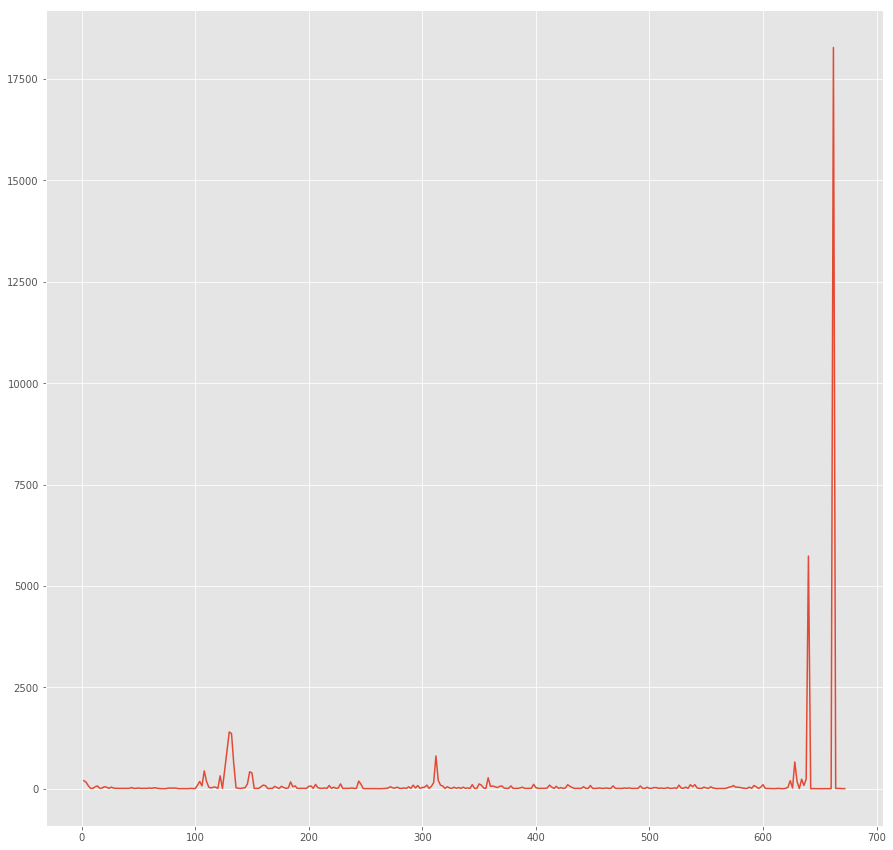

In [12]:
test.ts.diff().plot(figsize=(15, 15))

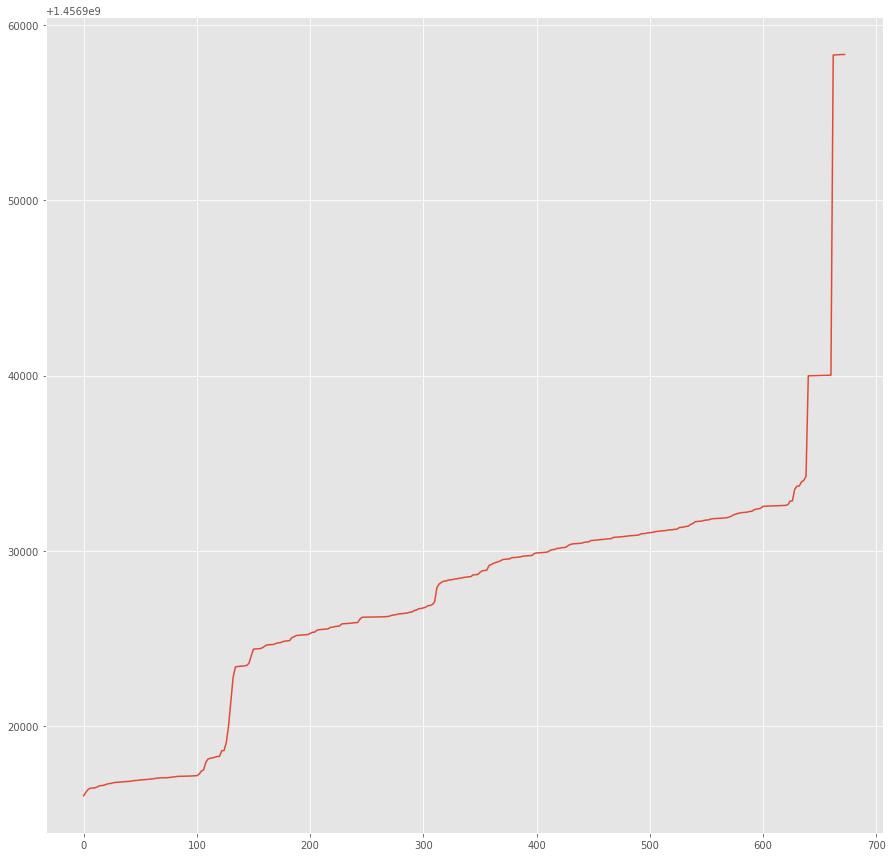

In [13]:
test.ts.plot(figsize=(15, 15))

In [91]:
test.ts.diff()

0          NaN
2        200.0
4        160.0
6         71.0
8          9.0
10        11.0
12        50.0
14        69.0
16        11.0
18        19.0
20        50.0
22        40.0
24        10.0
26        40.0
28        20.0
30        10.0
32        11.0
34         9.0
36        11.0
38         9.0
40        10.0
42        10.0
44        30.0
46        10.0
48        10.0
50        20.0
52        10.0
54        10.0
56        10.0
58        11.0
        ...   
614       10.0
616        3.0
618        4.0
620       10.0
622       40.0
624      200.0
626       19.0
628      660.0
630      178.0
632        6.0
634      236.0
636       81.0
638      239.0
640     5737.0
642        3.0
644        5.0
646        3.0
648        3.0
650        3.0
652        4.0
654        4.0
656        3.0
658        3.0
660        6.0
662    18278.0
664        8.0
666        8.0
668        9.0
670        4.0
672        3.0
Name: ts, Length: 335, dtype: float64

In [92]:
test.ts.describe()


count    3.350000e+02
mean     1.456927e+09
std      7.124694e+03
min      1.456916e+09
25%      1.456925e+09
50%      1.456928e+09
75%      1.456931e+09
max      1.456958e+09
Name: ts, dtype: float64

In [94]:
test.ts.diff().mean()


126.7185628742515

In [109]:
outlier_indices = detect_outliers(test.ts, alpha=1.25)

In [110]:
outlier_indices

[318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334]

In [111]:
clean_test = test.drop(test.index[outlier_indices])

### Plotting the (Timestamp-Outlier-Free) Dataset...

### ...vs.The Original Trajectory

In [112]:
test.ts.plot(figsize=(15, 15))

In [113]:
clean_test.ts.plot(figsize=(15, 15))

In [116]:
test.plot(figsize=(15, 15))

In [117]:
clean_test.plot(figsize=(15, 15))

In [18]:
test.count()

level_0    317
index      317
id         317
mmsi       317
status     317
turn       317
speed      317
course     317
heading    317
lon        317
lat        317
ts         317
geom       317
dtype: int64

## Potential Area-of-Activity (PAA) Denoising
### Approximating the Problem with Velocity Outliers rather than using a Velocity Threshold
* ### __TODO__: Find the Velocity Threshold for the Fishing Boats

In [47]:
sample_ves_espg3857_nd = sample_ves_espg3857.drop_duplicates(subset=['ts'])
sample_ves_espg3857_nd.head(2)

level_0  index        id       mmsi  status   turn  speed  course  heading  \
0      267  82362  12697067  371415000     0.0  127.0   11.1    71.0       65   
2      268  82584  12697289  371415000     0.0    0.0   11.5    71.0       65   

        lon        lat          ts  \
0 -5.378398  48.042583  1456916014   
2 -5.363332  48.046017  1456916214   

                                           geom  
0   POINT (-598720.571171356 6113942.054820082)  
2  POINT (-597043.3871952686 6114513.841228255)

In [48]:
sample_ves_espg3857_nd.geom

0       POINT (-598720.571171356 6113942.054820082)
2      POINT (-597043.3871952686 6114513.841228255)
4      POINT (-595701.9428034156 6114932.964563244)
6      POINT (-595095.2961063879 6115115.973190749)
8       POINT (-595008.0661534017 6115138.28752164)
10     POINT (-594922.7174998093 6115162.933268012)
12     POINT (-594494.1374602573 6115290.659318012)
14     POINT (-593883.7504283399 6115485.166266123)
16     POINT (-593796.5316073027 6115510.146073989)
18     POINT (-593633.2593101555 6115557.441376179)
20     POINT (-593204.6904025495 6115682.009124545)
22     POINT (-592874.4166053174 6115779.266485437)
24     POINT (-592792.7637588191 6115804.913302059)
26      POINT (-592431.031073485 6115909.832896073)
28      POINT (-592271.454583435 6115951.468011378)
30     POINT (-592180.5399553035 6115987.607455348)
32     POINT (-592093.3433981639 6116015.586484314)
34     POINT (-592006.1802368737 6116040.234752133)
36     POINT (-591918.9502838877 6116065.049633872)
38     POINT

In [18]:
sample_ves_espg3857_nd.geom.shift()

0                                               NaN
2       POINT (-598720.571171356 6113942.054820082)
4      POINT (-597043.3871952686 6114513.841228255)
6      POINT (-595701.9428034156 6114932.964563244)
8      POINT (-595095.2961063879 6115115.973190749)
10      POINT (-595008.0661534017 6115138.28752164)
12     POINT (-594922.7174998093 6115162.933268012)
14     POINT (-594494.1374602573 6115290.659318012)
16     POINT (-593883.7504283399 6115485.166266123)
18     POINT (-593796.5316073027 6115510.146073989)
20     POINT (-593633.2593101555 6115557.441376179)
22     POINT (-593204.6904025495 6115682.009124545)
24     POINT (-592874.4166053174 6115779.266485437)
26     POINT (-592792.7637588191 6115804.913302059)
28      POINT (-592431.031073485 6115909.832896073)
30      POINT (-592271.454583435 6115951.468011378)
32     POINT (-592180.5399553035 6115987.607455348)
34     POINT (-592093.3433981639 6116015.586484314)
36     POINT (-592006.1802368737 6116040.234752133)
38     POINT

In [31]:
velocities = calculate_velocity(sample_ves_espg3857_nd)

In [32]:
velocities

2       8.859861
4       8.783724
6       8.924648
8      10.004316
10      8.075985
12      8.944156
14      9.284476
16      8.247771
18      8.946546
20      8.926106
22      8.607401
24      8.558590
26      9.416032
28      8.245929
30      9.783419
32      8.325042
34     10.064578
36      8.244629
38     10.293333
40      9.065884
42      8.794792
44      8.686586
46      8.805330
48      9.072609
50      9.820713
52      7.152621
54      8.880143
56     10.897060
58      7.136460
60      8.922254
         ...    
614     1.134611
616     0.835420
618     1.732457
620     1.288796
622     1.444305
624     1.556156
626     1.809724
628     2.661210
630     2.971013
632     3.161013
634     3.260258
636     3.631772
638     3.949241
640     3.275259
642     2.723393
644     2.892037
646     1.985535
648     4.164245
650     1.829996
652     3.023101
654     1.543117
656     1.176924
658     4.066784
660     2.416413
662     1.176871
664     3.716679
666     2.114003
668     3.2292

In [33]:
sample_ves_espg3857_nd.speed

0      11.1
2      11.5
4      11.5
6      11.5
8      11.6
10     11.6
12     11.6
14     11.5
16     11.6
18     11.4
20     11.8
22     11.5
24     11.4
26     11.6
28     11.8
30     11.6
32     11.7
34     11.7
36     11.7
38     11.8
40     11.8
42     11.6
44     11.6
46     11.5
48     11.6
50     11.5
52     11.5
54     11.5
56     11.6
58     11.5
       ... 
614     1.6
616     1.7
618     1.7
620     1.6
622     2.0
624     2.3
626     2.2
628     4.4
630     3.0
632     3.3
634     4.5
636     4.6
638     4.6
640     3.0
642     2.5
644     2.9
646     3.2
648     2.9
650     2.8
652     3.3
654     2.8
656     2.9
658     3.1
660     2.9
662     3.9
664     3.7
666     3.7
668     3.6
670     3.2
672     3.3
Name: speed, Length: 335, dtype: float64

In [99]:
# outliers = detect_outliers(velocities, alpha=1.5)
outliers = detect_outliers(velocities, alpha=3)
print(outliers)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38, 40, 41, 45, 46, 49]


### Plotting the Outliers in the Original Trajectory...

### ...vs. The Deleted Points

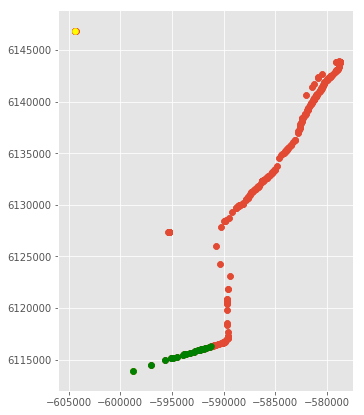

In [54]:
ax = sample_ves_espg3857.plot(figsize=(7, 7))
ax.scatter(sample_ves_espg3857.iloc[0].geom.x, sample_ves_espg3857.iloc[0].geom.y, c='yellow') 

ax.scatter(sample_ves_espg3857.iloc[-1].geom.x, sample_ves_espg3857.iloc[-1].geom.y, c='yellow')


# Points-of-Interest
ax.scatter(sample_ves_espg3857.iloc[outliers].geom.x, sample_ves_espg3857.iloc[outliers].geom.y, c='green')
# ctx.add_basemap(ax)
plt.show()

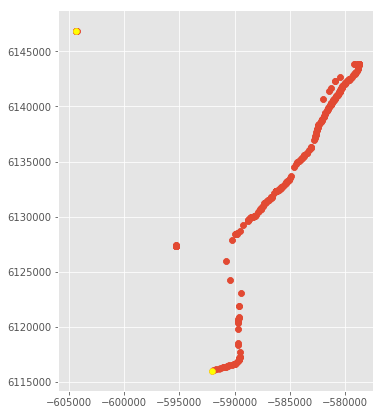

In [55]:
ax = sample_ves_espg3857.drop(outliers).plot(figsize=(7, 7))

ax.scatter(sample_ves_espg3857.drop(outliers).iloc[0].geom.x, sample_ves_espg3857.drop(outliers).iloc[0].geom.y, c='yellow') 
ax.scatter(sample_ves_espg3857.drop(outliers).iloc[-1].geom.x, sample_ves_espg3857.drop(outliers).iloc[-1].geom.y, c='yellow')


# Points-of-Interest
# ax.scatter(sample_ves_espg3857.iloc[outliers].geom.x, sample_ves_espg3857.iloc[outliers].geom.y, c='green')
# ctx.add_basemap(ax)
plt.show()

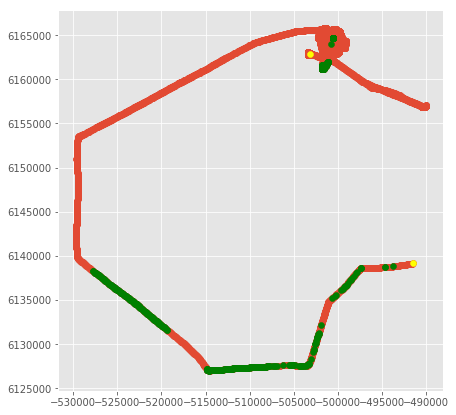

In [140]:
ax = sample_ves_espg3857.plot(figsize=(7, 7))
ax.scatter(sample_ves_espg3857.iloc[0].geom.x, sample_ves_espg3857.iloc[0].geom.y, c='yellow') 

ax.scatter(sample_ves_espg3857.iloc[-1].geom.x, sample_ves_espg3857.iloc[-1].geom.y, c='yellow')


# Points-of-Interest
ax.scatter(sample_ves_espg3857.iloc[outliers].geom.x, sample_ves_espg3857.iloc[outliers].geom.y, c='green')
# ctx.add_basemap(ax)
plt.show()

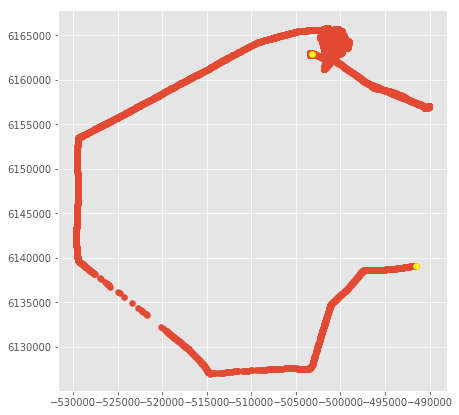

In [141]:
ax = sample_ves_espg3857.drop(outliers).plot(figsize=(7, 7))

ax.scatter(sample_ves_espg3857.iloc[0].geom.x, sample_ves_espg3857.iloc[0].geom.y, c='yellow') 
ax.scatter(sample_ves_espg3857.iloc[-1].geom.x, sample_ves_espg3857.iloc[-1].geom.y, c='yellow')


# Points-of-Interest
# ax.scatter(sample_ves_espg3857.iloc[outliers].geom.x, sample_ves_espg3857.iloc[outliers].geom.y, c='green')
# ctx.add_basemap(ax)
plt.show()

## TESTING: Detecting Outliers \w Pandas vs. NumPy

In [103]:
%timeit detect_outliers(velocities, alpha=3)

327 µs ± 6.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [104]:
%timeit get_outliers(velocities, alpha=3)

933 µs ± 19.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## TESTING: (Geo)Pandas Distance vs. Other Mehods

In [22]:
sample_ves_espg3857_nd.geom.distance(sample_ves_espg3857_nd.geom.shift())

0               NaN
2       1771.972287
4       1405.395826
6        633.650040
8         90.038848
10        88.835834
12       447.207775
14       640.628817
16        90.725485
18       169.984378
20       446.305313
22       344.296058
24        85.585902
26       376.641284
28       164.918583
30        97.834191
32        91.575464
34        90.581200
36        90.690920
38        92.639998
40        90.658839
42        87.947924
44       260.597580
46        88.053301
48        90.726092
50       196.414267
52        71.526213
54        88.801431
56       108.970602
58        78.501061
           ...     
614       11.346115
616        2.506261
618        6.929827
620       12.887956
622       57.772199
624      311.231111
626       34.384756
628     1756.398447
630      528.840402
632       18.966080
634      769.420776
636      294.173522
638      943.868717
640    18790.161629
642        8.170178
644       14.460186
646        5.956606
648       12.492736
650        5.489987


In [23]:
for idx, i in enumerate(sample_ves_espg3857_nd.geom[:-1]):
    print (i.distance(sample_ves_espg3857_nd.geom.iloc[idx+1]))

1771.9722870901592
1405.395825511904
633.6500396559031
90.0388475107471
88.83583446053939
447.2077751459337
640.6288173319888
90.72548453512772
169.9843775908683
446.30531309838227
344.29605775503995
85.58590155008639
376.64128404498905
164.91858295278936
97.8341914602996
91.57546417518354
90.58119999542001
90.6909204585821
92.63999838850415
90.6588393689038
87.94792414738184
260.59758006451545
88.053301465516
90.72609233900735
196.4142667096822
71.52621270046289
88.80143058157222
108.97060203461893
78.50106084234055
178.44507516310006
92.64034321414502
238.94713788514315
154.35517049535508
65.20297674540774
15.365486432163102
25.01874955194932
18.545636313059894
106.58030035471609
166.59880917928575
80.1099304285938
132.73597520740688
64.58323791994496
16.708313467402558
17.719430767669436
24.156350154404922
24.643941696311078
23.69085465622506
58.305429737660745
33.81290526883925
24.327666177049313
408.1655785506352
692.8744490087596
180.654555224917
1296.868776301149
552.96322780197

In [24]:
for idx, i in enumerate(sample_ves_espg3857_nd.geom[:-1]):
    j = sample_ves_espg3857_nd.geom.iloc[idx+1]
    x1, y1 = i.x, i.y
    x2, y2 = j.x, j.y
    print (np.sqrt( (x1 - x2)**2 + (y1 - y2)**2 )) 

1771.9722870901592
1405.395825511904
633.6500396559031
90.0388475107471
88.83583446053939
447.2077751459337
640.6288173319888
90.72548453512772
169.9843775908683
446.30531309838227
344.29605775503995
85.58590155008639
376.64128404498905
164.91858295278936
97.8341914602996
91.57546417518354
90.58119999542001
90.6909204585821
92.63999838850415
90.6588393689038
87.94792414738184
260.59758006451545
88.053301465516
90.72609233900735
196.4142667096822
71.52621270046289
88.80143058157222
108.97060203461893
78.50106084234055
178.44507516310006
92.64034321414502
238.94713788514315
154.35517049535508
65.20297674540774
15.365486432163102
25.01874955194932
18.545636313059894
106.58030035471609
166.59880917928575
80.1099304285938
132.73597520740688
64.58323791994496
16.708313467402558
17.719430767669436
24.156350154404922
24.643941696311078
23.69085465622506
58.305429737660745
33.81290526883925
24.327666177049313
408.1655785506352
692.8744490087596
180.654555224917
1296.868776301149
552.96322780197

# FUNCTIONS

In [25]:
def calculate_velocity(df):
    dx = df.geom.distance(df.geom.shift()).dropna()
    dt = df.ts.diff().dropna()
    velocity = dx/dt
    return velocity

In [26]:
def resample_trajectory(df, alpha=1.25):
    '''
        Denoise a Trajectory given the "Outlier" Timestamp Indices.
    '''
    df_clean = df.drop_duplicates(subset=['ts'])
    outlier_indices = detect_outliers(df_clean.ts, alpha=alpha)
    df_clean = df_clean.drop(df_clean.index[outlier_indices])
    
    return df_clean

In [27]:
def detect_outliers(feature_series, alpha=1.25):
    values = np.array(feature_series)
    Q75 = np.percentile(values, 75)
    Q25 = np.percentile(values, 25)
    iqr = Q75 - Q25
    
    outliers_idx = []
    for idx, val in enumerate(values):
        if val > Q75 + (alpha * iqr):
            outliers_idx.append(idx)
        elif val < Q25 - (alpha * iqr):
            outliers_idx.append(idx)
    return outliers_idx

In [28]:
def get_outliers(series, alpha = 3):
    q25, q75 = series.quantile((0.25, 0.75))
    iqr = q75 - q25
    q_high = q75 + alpha*iqr
    q_low = q25 - alpha*iqr
    return series.loc[(series >q_high) | (series<q_low)].index

In [29]:
def mean_dist_between_concecutive_points(sample_ves):
    mean_dt = sample_ves.geom.distance(sample_ves.geom.shift(-1)).mean()
    min_val = 1
    for point in tqdm_notebook(sample_ves.geom):
        if abs(sample_ves.geom.distance(point) - mean_dt).min() < min_val:
            min_val = abs(sample_ves.geom.distance(point) - mean_dt).min()
            cords = (abs(sample_ves.geom.distance(point) - mean_dt).idxmin(), (sample_ves.loc[sample_ves.geom == point ].index)[0])
    return sample_ves.loc[[i for i in cords]], min_val

In [30]:
def get_mean_distance_between_points(sample_ves):
    sum_fl = 0.0
    for point in tqdm_notebook(sample_ves.geom):
        sum_fl += sample_ves.geom.distance(point).mean()
        mean_dt = sum_fl/sample_ves.geom.count()
    return mean_dt

In [56]:
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)